In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import local_utils
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from local_utils import ResidualBlock
from torch import nn

### The first part of the class is dedicated to training our own network for classification. We will use the MNIST dataset and the MiniResNet model for this purpose. At the end we will do an evaluation on the CPU and GPU.

# 1. Preparation of the dataset

MNIST is a database of handwritten digits. It contains 60,000 training and 10,000 test images with a size of 28 x 28. The PyTorch library enables us to retrieve the data easily using the `datasets.MNIST` function:
- `root` - the path where the data will be saved,
- `train` - we select whether the collection is training or testing (`True/False`),
- `download` - if we want to download the data

The downloaded and prepared data, we then pass to the DataLoaders, which will be used for training and testing:
- `dataset` - we specify the loaded datasets,
- `batch_size` - the amount of data in one batch. The data is not large, so you can set the parameter to 64.
- `shuffle` - whether the data will be shuffled. This is required during training.

At the end, you can check that the data has been prepared correctly. The dimension of the data batch for the MNIST set, should be (batch_size, 1, 28, 28), while the labels should be in the range 0-9.

If in any doubt, please refer to the documentation of the functions used:

https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [6]:
batchsize = 64

#image datasets
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
test_dataset  = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

#data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

for X, Y in train_loader:
    print("Data batch shape = ", np.shape(X.numpy()))
    print("Labels for batch = ", Y.numpy())
    break

100%|██████████| 9912422/9912422 [00:38<00:00, 259781.16it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1244715.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:02<00:00, 594050.04it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 721419.65it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Data batch shape =  (64, 1, 28, 28)
Labels for batch =  [8 8 9 5 1 6 0 1 3 3 8 0 8 6 7 2 7 6 1 7 4 1 4 2 1 8 5 3 7 8 5 3 2 3 2 2 8
 0 1 1 3 8 5 4 6 6 8 9 3 9 6 2 1 5 3 5 6 1 2 9 3 9 9 4]


Data batch shape =  (64, 1, 28, 28)
Labels for batch =  [7 5 2 4 0 9 0 1 1 5 5 5 0 8 4 8 4 8 9 4 9 2 3 3 1 8 6 8 6 8 9 6 5 2 1 9 3
 9 8 1 5 7 5 0 5 4 1 3 3 7 8 4 9 3 1 8 3 1 6 7 0 7 2 0]


# 2. Model preparation

We create the MiniResNet class:
- we set `input_shape`  corresponding to the data (CH, H, W). 
- we set `num_of_classes` corresponding to the data,

The part responsible for feature extraction `(CNN)` is built with 2D convolution layers, Max Pooling, ReLU and residual blocks (their implementation can be found in the local_utils.py file).


The `(FC)` classifier part, on the other hand, consists of a flattening layer, a linear layer and a softmax layer. 


PyTorch allows us to create networks using the `nn.Module` class. The `nn.sequential` container allows us to initialise the layers in the correct order. The `forward` function calls the convolution part `CNN` and then the classifier part `FC`.


Please fill in the missing data. The principle of each layer is described in detail in the PyTorch documentation:

https://pytorch.org/docs/stable/nn.html

In [17]:
class MiniResNet(nn.Module):
    def __init__(self, 
                 input_shape = (1, 28, 28), #......TODO.........
                 num_of_classes = 10, #......TODO.........
                 ) -> None:
        super().__init__()
        self.CNN = nn.Sequential(
                                nn.Conv2d(input_shape[0], 16, 3, padding=1),
                                nn.ReLU(),
            
                                ResidualBlock(16,4,3),
    
                                nn.Conv2d(16, 32, 3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
            
                                ResidualBlock(32,4,3),
                                ResidualBlock(32,2,3),

                                nn.Conv2d(32, 64, 3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
                                

                                ResidualBlock(64,8,3),
                                ResidualBlock(64,16,3),
    

                                nn.Conv2d(64, 128, 3),
                                nn.ReLU(),
                                nn.Conv2d(128, 128, 3),
                                nn.ReLU(),
                                )
        CNN_out_shape = [
                         128,
                         input_shape[-2]//2//2 - 3//2*2 - 3//2*2,
                         input_shape[-1]//2//2 - 3//2*2 - 3//2*2
                        ]
        CNN_flatten_len = torch.prod(torch.tensor(CNN_out_shape))

        self.FC = nn.Sequential(
                                # Flatten
                                #......TODO.........
                                nn.Flatten(start_dim=1, end_dim=-1),
                                # Linear (in=CNN_flatten_len, out=number of classes)
                                #......TODO.........
                                nn.Linear(in_features=CNN_flatten_len, out_features=num_of_classes),
                                # Softmax (dimension = 1)
                                #......TODO.........
                                nn.Softmax(dim=1),
                               )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.FC(self.CNN(x))

We create a network instance. We can display the entire architecture using `print`.

In [12]:
input_shape = train_loader.dataset[0][0].shape     # CHW format for MNIST
num_of_classes = len(train_loader.dataset.classes) # Number of classes in MNIST
model = MiniResNet(input_shape, num_of_classes)

print(model)

MiniResNet(
  (CNN): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ResidualBlock(
      (L1): Sequential(
        (0): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (L2): Sequential(
        (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ResidualBlock(
      (L1): Sequential(
        (0): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True,

# 3. Network training

We start by looking at the available computing resources. If possible, we want to train on the GPU (CUDA). We load the model on the device. We can check on which device we will be working.

https://pytorch.org/docs/stable/tensor_attributes.html#torch.device

In [16]:
device = torch.device('cpu') # TODO

# model.to(...) #TODO
print(device)

cpu


We now proceed with the training. We will use the `training` function from the local_utils.py file. It takes as arguments respectively:
- `model` - we specify our model,
- `train_loader` / `test_loader` - these are respectively prepared DataLoaders with training/testing data,
- `loss_fcn` - we will use the `CrossEntropyLoss` function from the `torch.nn` library with the parameter `reduction='mean'`,
- `metric` - we will use the Accuracy metric, implemented in the local_utils file (`AccuracyMetric`),
- `epoch_max` - we set the number of epochs to 5 (this parameter can be modified, but a small value will make the network inaccurate, while a large value will make us wait a long time for the result and there may be an overtraining effect!),
- `device` - specify the available device, same as with the model,
- `update_period` - please set to `5`,
- `optimizer` - we will use `SGD` (Stochastic Gradient Descent) from the torch.optim library. We specify the model parameters and a learning rate equal to `0.1` (please refer to the documentation).

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

In [6]:
loss_fcn = ... #TODO
metric = ... #TODO
epoch = ... #TODO
update_period = ... #TODO
optimizer = ... #TODO

model, history = local_utils.training(model=model, 
                                    train_loader=train_loader, 
                                    test_loader=test_loader, 
                                    loss_fcn=loss_fcn,
                                    metric=metric,
                                    optimizer=optimizer,
                                    update_period=update_period,
                                    epoch_max=epoch,
                                    device=device)

Epoch 1 / 5: STARTED
TRAINING
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


938it [00:37, 25.09it/s]


VALIDATION
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


157it [00:02, 65.80it/s]



After epoch 1: loss=1.8006 acc=0.6595 val_loss=1.6098 val_acc=0.8510
Epoch 1 / 5: FINISHED

Epoch 2 / 5: STARTED
TRAINING
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


938it [00:36, 25.71it/s]


VALIDATION
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


157it [00:02, 62.57it/s]



After epoch 2: loss=1.5238 acc=0.9385 val_loss=1.4964 val_acc=0.9642
Epoch 2 / 5: FINISHED

Epoch 3 / 5: STARTED
TRAINING
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


938it [00:36, 25.64it/s]


VALIDATION
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


157it [00:02, 64.82it/s]



After epoch 3: loss=1.4864 acc=0.9756 val_loss=1.4809 val_acc=0.9809
Epoch 3 / 5: FINISHED

Epoch 4 / 5: STARTED
TRAINING
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


938it [00:37, 25.06it/s]


VALIDATION
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


157it [00:02, 63.12it/s]



After epoch 4: loss=1.4807 acc=0.9810 val_loss=1.4785 val_acc=0.9834
Epoch 4 / 5: FINISHED

Epoch 5 / 5: STARTED
TRAINING
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


938it [00:36, 25.60it/s]


VALIDATION
Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


157it [00:02, 65.80it/s]


After epoch 5: loss=1.4775 acc=0.9842 val_loss=1.4794 val_acc=0.9823
Epoch 5 / 5: FINISHED



We can display the training history with the `plot_history` function from local_utils. We just feed the `history` value from the `training` function to it. The expected value of `acc` and `val_acc` should be at the 98% level.

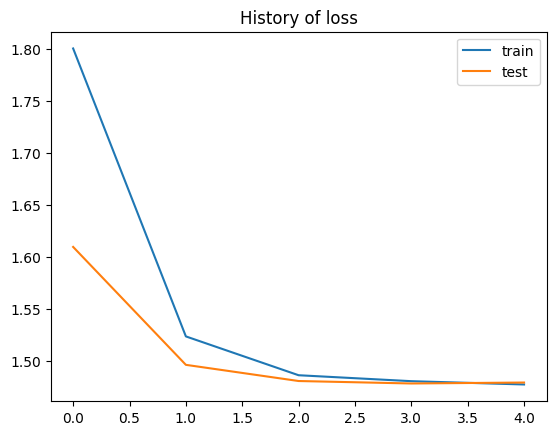

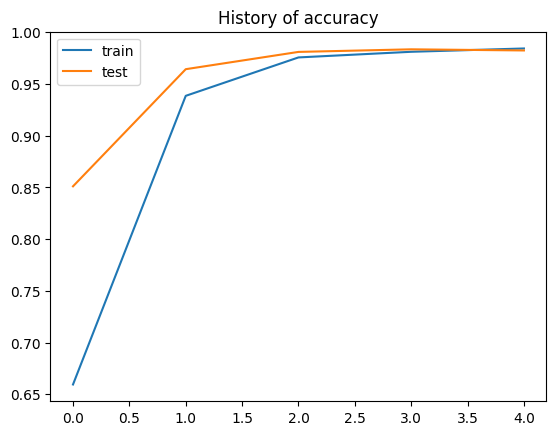

In [7]:
local_utils.plot_history(history)

Save the trained model to the file `MNIST.pth`. It will be useful later in the exercise.

In [8]:
sd = {'model': model.state_dict(), 'opt': optimizer.state_dict()}
torch.save(sd, 'MNIST.pth', _use_new_zipfile_serialization=False)

# 4. Model evaluation.

We will test the learned model on both the CPU and the GPU (if available). 

We start by creating a new DataLoader. We will use the test collection for it, just as we did at the beginning, but we will set the `batch_size` value to 1.

In [9]:
eval_loader = DataLoader(...) #TODO

We set the device parameter to `cuda`.

We create a new instance of the `MiniResNet` model, load the learned weights `MNIST.pth` with the `torch.load` function with the `map_location` parameter as the device on which the operation will be performed. With the `load_state_dict` function we load the data into the new model and load it onto the hardware.

The `TimeMeasurement` function from `local_utils` allows us to check the time results of the model.

We run the `train_test_pass` function. We specify our model, data generator, loss function, metric and device. We set `test` as `mode`. The `Optimizer` and `update_period` can be set to `None`.

In [10]:
device = ... #TODO

evalModel = ... #TODO
pretrainedModel = ... #TODO
evalModel.load_state_dict(pretrainedModel['model'])
evalModel.to(...) #TODO

tm = local_utils.TimeMeasurement("Host-GPU", len(eval_loader))

with tm:
 
    evalModel, loss, acc = local_utils.train_test_pass(model=evalModel,
                                                       data_generator=eval_loader,
                                                       criterion=loss_fcn,
                                                       metric=metric,
                                                       optimizer=None,
                                                       update_period=None,
                                                       mode='test',
                                                       device=device)
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


10000it [00:21, 466.47it/s]

TimeMeasurement(context="Host-GPU","0.0:0.0:21:443", frames=10000, throughput=466.35083935009993)
loss: 1.4794007679581642
acc: 0.9823


We perform the same operation, but this time we set `cpu` as the device.

In [11]:
device = ... #TODO

evalModel = ... #TODO
pretrainedModel = ... #TODO
evalModel.load_state_dict(pretrainedModel['model'])
evalModel.to(...) #TODO

tm = local_utils.TimeMeasurement("Host-CPU", len(eval_loader))

with tm:
    # TODO
    evalModel, loss, acc = local_utils.train_test_pass(model=evalModel,
                                                       data_generator=eval_loader,
                                                       criterion=loss_fcn,
                                                       metric=metric,
                                                       optimizer=None,
                                                       update_period=None,
                                                       mode=..., #TODO
                                                       device=device)
    
print(repr(tm))
print("loss:", loss)
print("acc:", acc)

Running on platform: Linux-5.15.0-67-generic-x86_64-with-glibc2.31, machine: x86_64, python_version: 3.9.16, processor: x86_64, system: Linux, 


10000it [00:18, 532.97it/s]

TimeMeasurement(context="Host-CPU","0.0:0.0:18:766", frames=10000, throughput=532.873084967341)
loss: 1.4794006655454635
acc: 0.9823


Please make a note of the performance accuracy and throughput (value in FPS). After this part, only the `MNIST.pth` file will be used. 

# 5. Further exercise

We will now proceed to the quantisation of the model. To do this, start the Docker image:

In the same folder, start a new terminal and run the command:

`sudo bash ./docker_run.sh xilinx/vitis-ai:1.4.916`.

After typing your sudo password (`lsriw`), click enter until asked. Type `y` and confirm.
When Vitis AI appears, start the conda environment for PyTorch:

`conda activate vitis-ai-pytorch`.

Finally, start jupyter notebook with the following command:

`jupyter notebook --no-browser --ip=0.0.0.0 --NotebookApp.token='' --NotebookApp.password=''`.

An http link will appear in the console. Right click and open the link. Disable this notepad and navigate to the quantize.ipynb file in running Jupyter.

------------------------------------------------------------------------------------------------------
NOTE: This is not the same Jupyter we were working now. 
The current Jupyter was running in a system conda environment. This allowed us to work with both CUDA and CPU at the same time.
The launched Jupyter is in Docker, which is configured for quantisation with Vitis AI. There, only the CPU is available.